In [1]:
import keras
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Dense,Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras.initializers import RandomNormal
import cv2
import numpy as np
from skimage.transform import resize
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from utils import *

Using TensorFlow backend.


In [2]:
x_train = read_train_images()
x_val = read_validation_images()

/anaconda2/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [3]:
y_train = read_train_labels()
y_val = read_validation_labels()

In [4]:
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.2,random_state=13)

In [5]:
print("Training set (images) shape: {shape}".format(shape=x_train.shape))
print("Validation set (images) shape: {shape}".format(shape=x_val.shape))
print("Test set (images) shape: {shape}".format(shape=x_test.shape))

Training set (images) shape: (467, 128, 128, 3)
Validation set (images) shape: (386, 128, 128, 3)
Test set (images) shape: (97, 128, 128, 3)


In [6]:
batch_size = 32
epochs = 10
inChannel = 3
x, y = 128, 128
input_img = Input(shape = (x, y, inChannel))
num_classes = 2

In [7]:
# Defines the encoder
def encoder(input_img, rand_weights):    
    rand_weights_init = RandomNormal(mean=0.0, stddev=0.05)
    if rand_weights: 
        conv1 = Conv2D(32, (3, 3), data_format="channels_last", activation='relu', padding='same',
                      kernel_initializer=rand_weights_init)(input_img)
    else:
        conv1 = Conv2D(32, (3, 3), data_format="channels_last", activation='relu', padding='same')(input_img)
        
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), data_format="channels_last", activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), data_format="channels_last", activation='relu', padding='same')(pool2)
    
    return conv3

In [8]:
def fully_connected(encoder):
    drop1 = Dropout(rate=0.2)(encoder)
    flat = Flatten()(drop1)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [9]:
autoencoder = read_model('autoencoder_color')

Instructions for updating:
Colocations handled automatically by placer.
Loaded model from disk


In [10]:
encode = encoder(input_img, rand_weights=False)
full_model = Model(input_img, fully_connected(encode))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
print('Number of layers in the full model: ' + str(len(full_model.layers)))

Number of layers in the full model: 10


In [12]:
# The first 6 layer are the autoencoder layers
for l1,l2 in zip(full_model.layers[:6], autoencoder.layers[:6]):
    l1.set_weights(l2.get_weights())

In [13]:
# Make the encoder part - trainable false. 
# The encoder part is already trained, so no need to train it. 
# Only train the Fully Connected part
for layer in full_model.layers[0:6]:
    layer.trainable = False

In [14]:
# Compile the model
full_model.compile(loss=keras.losses.categorical_crossentropy, 
                   optimizer=keras.optimizers.Adam(),
                   metrics=['accuracy'])


In [15]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
__________

In [16]:
classify_train = full_model.fit(x_train, 
                                y_train, 
                                batch_size=batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(x_val, y_val))


Instructions for updating:
Use tf.cast instead.
Train on 467 samples, validate on 386 samples
Epoch 1/10
467/467 [==============================] - 16s 35ms/step - loss: 0.5442 - acc: 0.7687 - val_loss: 0.3334 - val_acc: 0.8938
Epoch 2/10
467/467 [==============================] - 14s 30ms/step - loss: 0.1707 - acc: 0.9465 - val_loss: 0.2820 - val_acc: 0.9093
Epoch 3/10
467/467 [==============================] - 14s 30ms/step - loss: 0.0916 - acc: 0.9657 - val_loss: 0.2896 - val_acc: 0.9171
Epoch 4/10
467/467 [==============================] - 14s 31ms/step - loss: 0.0360 - acc: 0.9893 - val_loss: 0.2942 - val_acc: 0.9171
Epoch 5/10
467/467 [==============================] - 15s 32ms/step - loss: 0.0162 - acc: 1.0000 - val_loss: 0.3494 - val_acc: 0.9197
Epoch 6/10
467/467 [==============================] - 15s 32ms/step - loss: 0.0085 - acc: 1.0000 - val_loss: 0.3390 - val_acc: 0.9041
Epoch 7/10
467/467 [==============================] - 15s 32ms/step - loss: 0.0056 - acc: 1.0000 - val

In [17]:
# Save the model
save_model(full_model, 'autoencoder_classification.h5')

Saved model to disk


In [ ]:
# Re-train the model by making the first 6 layers trainable as True instead of keeping them False
# for layer in full_model.layers[0:6]:
#     layer.trainable = True

In [18]:
encode_2 = encoder(input_img, rand_weights=True)
full_model_2 = Model(input_img, fully_connected(encode_2))

In [19]:
full_model_2.compile(loss=keras.losses.categorical_crossentropy, 
                     optimizer=keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [20]:
# Train the model for last time
classify_train_2 = full_model_2.fit(x_train, 
                                    y_train, 
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_val, y_val))

Train on 467 samples, validate on 386 samples
Epoch 1/10
467/467 [==============================] - 27s 58ms/step - loss: 0.8453 - acc: 0.6274 - val_loss: 0.3791 - val_acc: 0.8601
Epoch 2/10
467/467 [==============================] - 26s 57ms/step - loss: 0.3933 - acc: 0.8437 - val_loss: 0.4615 - val_acc: 0.8031
Epoch 3/10
467/467 [==============================] - 27s 58ms/step - loss: 0.3370 - acc: 0.8694 - val_loss: 0.3062 - val_acc: 0.8964
Epoch 4/10
467/467 [==============================] - 25s 54ms/step - loss: 0.2466 - acc: 0.9036 - val_loss: 0.2754 - val_acc: 0.9041
Epoch 5/10
467/467 [==============================] - 26s 57ms/step - loss: 0.2353 - acc: 0.9122 - val_loss: 0.3005 - val_acc: 0.8860
Epoch 6/10
467/467 [==============================] - 25s 55ms/step - loss: 0.2193 - acc: 0.9101 - val_loss: 0.3004 - val_acc: 0.8990
Epoch 7/10
467/467 [==============================] - 28s 59ms/step - loss: 0.1412 - acc: 0.9465 - val_loss: 0.2841 - val_acc: 0.9093
Epoch 8/10
467/4

In [21]:
# Save the model
save_model(full_model_2, 'classification_rand_weights.h5')

Saved model to disk


In [24]:
# Plot accuracy and loss plots between training and validation data
def plot_acc_loss_curves(classify_train):
    accuracy = classify_train.history['acc']
    val_accuracy = classify_train.history['val_acc']
    loss = classify_train.history['loss']
    val_loss = classify_train.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    print('Acc: ' + str(accuracy))
    print('Validtion Acc: ' + str(val_accuracy))
    print('Loss: ' + str(loss))
    print('Validtion Loss: ' + str(val_loss))

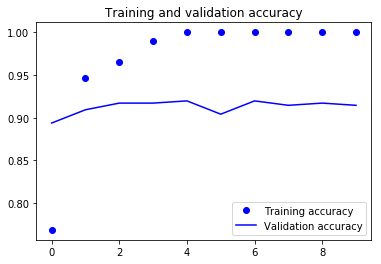

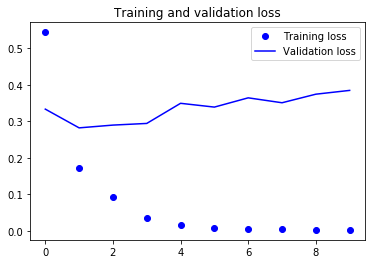

Acc: [0.7687366178510531, 0.946466810315273, 0.9657387580299786, 0.9892933618843683, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Validtion Acc: [0.8937823834196891, 0.9093264248704663, 0.917098445595855, 0.917098445595855, 0.9196891191709845, 0.9041450777202072, 0.9196891191709845, 0.9145077720207254, 0.917098445595855, 0.9145077720207254]
Loss: [0.5441885714995529, 0.17069390971349188, 0.09162266997568612, 0.03595834434016486, 0.01618540909627903, 0.008507653372362256, 0.005625996180277565, 0.003776268166294461, 0.002791864398619603, 0.0022254827638242465]
Validtion Loss: [0.3333913631389796, 0.2820243544374723, 0.2896207890285111, 0.29416396063535327, 0.349353751138702, 0.3389690460859185, 0.3643505495099515, 0.3508541306837853, 0.37434494772375865, 0.3847382822474513]


In [25]:
plot_acc_loss_curves(classify_train)

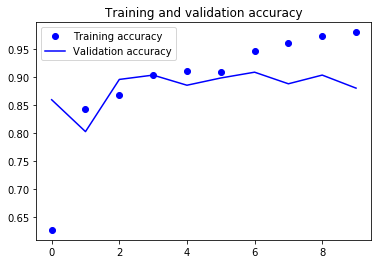

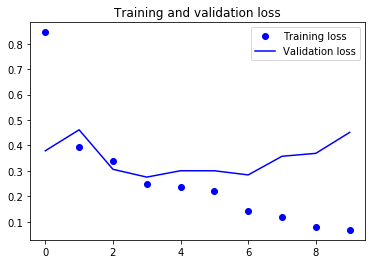

Acc: [0.6274089925549525, 0.8436830835117773, 0.8693790158827248, 0.9036402578527463, 0.9122055683452517, 0.9100642400839599, 0.946466810315273, 0.9614561036771574, 0.974304068522484, 0.9807280513918629]
Validtion Acc: [0.8601036269430051, 0.8031088082901554, 0.8963730569948186, 0.9041450777202072, 0.8860103626943006, 0.8989637305699482, 0.9093264248704663, 0.8886010362694301, 0.9041450777202072, 0.8808290155440415]
Loss: [0.8453391337292608, 0.3932917343344882, 0.33698301199161523, 0.2465757182629767, 0.23529757291270018, 0.2192642222571424, 0.14119509612339723, 0.11845119940456027, 0.08105189795157128, 0.0676519005246285]
Validtion Loss: [0.37907208278389176, 0.4615293721924174, 0.3061826236044187, 0.275423447895853, 0.3004597965145358, 0.3003582541343462, 0.2840634897988232, 0.3574267610367098, 0.36888650671815393, 0.451302045985207]


In [26]:
plot_acc_loss_curves(classify_train_2)

In [27]:
# Model evaluation on test set
def evaluate_test_set(full_model):
    test_eval = full_model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

In [28]:
evaluate_test_set(full_model)

Test loss: 0.6541930203683544
Test accuracy: 0.845360824742268


In [29]:
evaluate_test_set(full_model_2)

Test loss: 0.48711675163610485
Test accuracy: 0.8350515463917526


In [44]:
# Predict labels
def predict_labels(full_model): 
    predicted_classes = full_model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    return predicted_classes

In [51]:
# Plot few predicted images and their class
def plot_predicted_images(predicted_images):
    for i, predicted_image in enumerate(predicted_images[:6]):
        plt.subplot(2, 3, i+1)
        plt.imshow(x_test[predicted_image], cmap='gray', interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[predicted_image], y_test_flat[predicted_image]))
        plt.tight_layout()

In [52]:
# Classification report
def get_classification_report(predicted_classes, y_test_flat):
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    print(classification_report(y_test_flat, predicted_classes, target_names=target_names))

Found 82 correct labels


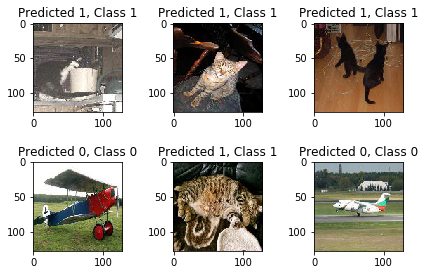

In [49]:
# For the first model (autoencoder + connected NN)
y_test_flat = np.argmax(y_test,axis=1)
predicted_classes = predict_labels(full_model)
correct = np.where(predicted_classes==y_test_flat)[0]
incorrect = np.where(predicted_classes!=y_test_flat)[0]

print("Found %d correct labels"% len(correct))
plot_predicted_images(correct)

Found 15 incorrect labels


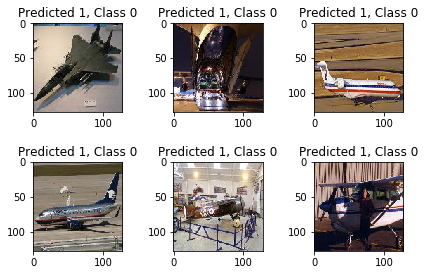

In [50]:
print("Found %d incorrect labels"% len(incorrect))
plot_predicted_images(incorrect)

Found 81 correct labels


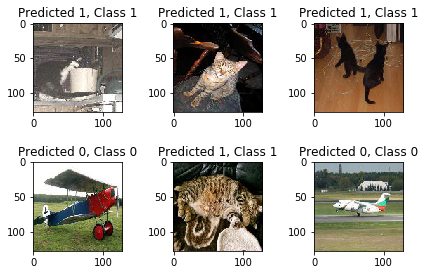

In [53]:
# For the second model
predicted_classes = predict_labels(full_model_2)
correct = np.where(predicted_classes==y_test_flat)[0]
incorrect = np.where(predicted_classes!=y_test_flat)[0]

print("Found %d correct labels"% len(correct))
plot_predicted_images(correct)

Found 16 incorrect labels


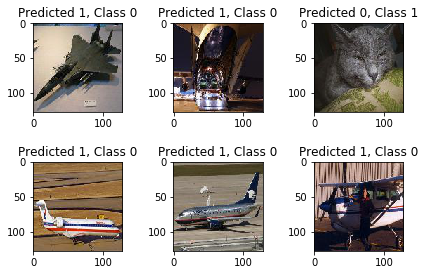

In [54]:
print("Found %d incorrect labels"% len(incorrect))
plot_predicted_images(incorrect)